In [1]:
setwd("~/Upd-Germline-Genomics")

source("_targets.R")

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
library(forcats)
library(GenomicRanges)
library(ggnewscale)
library(ggplot2)
library(ggrastr)
library(limma)
library(nnls)
library(pracma)
library(scales)
library(splines2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:utils’:

    findMatches


The following objects are mask

In [3]:
tar_load(
  c(
    matches("^chic.experiment.quantify_H3K(4|27|9)_(Germline|Somatic)_peakcalling.broad_chr"),
    chic.tile.diameter_1000_chr,
    chic.tile.diameter_500_score_chr,
    repli.chic.projection.profile_Germline_chr,
    repli.chic.projection.profile_Somatic_chr,
    repli.timing_Germline_chr,
    repli.timing_Somatic_chr
  )
)

### Fitting the Conic Section Segment

The H3K4me3-H3K27me3 response curve, parametrized by a suitable slice of
replication timing, may be a curve. However, it should not "turn around" too
much. Aligned to the axes, this is a test that each of f(t) and g(t) are either
nonincreasing or nondecreasing. Furthermore, the fit is a parabola segment or
line segment. The other types of conic sections don't support the idea of
"average slope of the fit" as straightforwardly, and are not fitted.

The parabola a(x - x0)^2 + bxy + c(y - y0)^2 + f = 0 has 6 degrees of freedom.
Fitting a conic section segment (parabola) is separable into fitting:
H3K4 = f(t), H3K27 = g(t).
f(t) and g(t) are in a vector space spanned by the intercept 1, and two
parabolic segments which have two different shapes. We chose two nondecreasing
shapes. There are two possible fits (nondecreasing: X, nonincreasing: -X) and
with intercept added, the coefficients should be nonnegative. The fit with a
greater sum of squares has smaller sum of squares error (a multiple of MSE), so
it is the MMSE optimal fit.

In [4]:
trend_input <- tibble(
  bind_rows(
    list(
      Germline = as.data.frame(repli.chic.projection.profile_Germline_chr),
      Somatic = as.data.frame(repli.chic.projection.profile_Somatic_chr)
    ),
    .id = "celltype"
  ),
  label = cut(repli, c(-Inf, -0.5, 0, 0.5, Inf)) %>%
    `levels<-`(value = c("L", "ML", "EM", "E")) %>%
    fct_relevel(c("E", "EM", "ML", "L")),
) %>%
  subset(sample_size_bp >= 500, select=c(celltype, label, repli, H3K4, H3K27))

In [5]:
trend <- tibble(
  bind_rows(
    list(
      Germline = as.data.frame(repli.chic.projection.profile_Germline_chr),
      Somatic = as.data.frame(repli.chic.projection.profile_Somatic_chr)
    ),
    .id = "celltype"
  ),
  label = cut(repli, c(-Inf, -0.5, 0, 0.5, Inf)) %>%
    `levels<-`(value = c("L", "ML", "EM", "E")) %>%
    fct_relevel(c("E", "EM", "ML", "L")),
) %>%
  subset(sample_size_bp >= 500, select=c(celltype, label, repli, H3K4, H3K27)) %>%
  group_by(celltype, label) %>%
  reframe(
    repli.new = list(
      E=seq(0.9, 0.5, by=-0.05),
      EM=seq(0.5, 0, by=-0.05),
      ML=seq(0, -0.5, by=-0.05),
      L=seq(-0.5, -1, by=-0.05)
    )[[as.character(label)[1]]],
    across(
      c(H3K4, H3K27),
      \(v) {
        v <- log(v) / log(2)
        x <- repli
        X <- cbind(
          Rising = ((x - min(x)) / (max(x) - min(x)))^2,
          Falling = 1 - ((max(x) - x) / (max(x) - min(x)))^2
        )
        Y <- v
        Yhat1 <- cbind(1, X)[!is.na(Y), ] %*% coef(nnls(cbind(1, X)[!is.na(Y), ], Y[!is.na(Y)]))
        Yhat2 <- cbind(1, -X)[!is.na(Y), ] %*% coef(nnls(cbind(1, -X)[!is.na(Y), ], Y[!is.na(Y)]))
        Yhat <- if (var(Yhat1) > var(Yhat2)) Yhat1 else Yhat2
        # rep(NA, length(Y)) %>% replace(!is.na(Y), Yhat)
        approx(repli, Yhat, xout = repli.new)$y
      }
    )
  ) %>%
  subset(!is.na(H3K4) & !is.na(H3K27)) %>%
  print()

# A tibble: 74 × 5
   celltype label repli.new  H3K4  H3K27
   <chr>    <fct>     <dbl> <dbl>  <dbl>
 1 Germline E          0.9  0.301 0.159 
 2 Germline E          0.85 0.273 0.126 
 3 Germline E          0.8  0.250 0.0975
 4 Germline E          0.75 0.230 0.0733
 5 Germline E          0.7  0.214 0.0535
 6 Germline E          0.65 0.201 0.0382
 7 Germline E          0.6  0.192 0.0273
 8 Germline E          0.55 0.187 0.0208
 9 Germline EM         0.5  0.191 0.0344
10 Germline EM         0.45 0.191 0.0465
# ℹ 64 more rows


### Extending the Conic Section Segment

In [6]:
arclength <- function(dx, d2x, dy, d2y, t0, t1) {
  # f(t) = 1/2 d2x t^2 + dx t + C
  # f'(t) = d2x t + dx
  # g(t) = 1/2 d2y t^2 + dy t + C
  # g'(t) = d2y t + dy
  # int sqrt(f'^2(t) + g'^2(t)) dt =
  #   int sqrt((d2x t + dx)^2 + (d2y t + dy)^2) dt =
  #   int sqrt((d2x^2 + d2y^2) t^2 + 2 (d2x dx + d2y dy) t + (dx^2 + dy^2)) dt
  A <- d2x^2 + d2y^2
  B <- 2 * (d2x * dx + d2y * dy)
  C <- dx^2 + dy^2
  integral(\(t) sqrt(A * t^2 + B * t + C), t0, t1)
}
arclength(1, 2, -1, -2, 0, 1)

[1] 2.828427

In [7]:
with(
  subset(trend, celltype == "Germline" & label == "E"),
  {
    print(diff(diff(H3K4)))
    print(diff(sqrt(diff(H3K4)^2 + diff(H3K27)^2)))
    dx <- head(diff(H3K4), 1)
    d2x <- head(diff(diff(H3K4)), 1)
    dy <- head(diff(H3K27), 1)
    d2y <- head(diff(diff(H3K27)), 1)
    print(arclength(dx, d2x, dy, d2y, 0, length(H3K4) - 1))
  }
)

[1] 0.003652271 0.003652271 0.003652271 0.003652271 0.003652271 0.003652271
[1] -0.005744744 -0.005744744 -0.005744744 -0.005744744 -0.005744744
[6] -0.005744744
[1] 0.1592443


In [8]:
trend_illu <- trend %>%
  group_by(celltype, label) %>%
  summarise(
    {
      dx <- head(diff(H3K4), 1)
      d2x <- head(diff(diff(H3K4)), 1)
      dy <- head(diff(H3K27), 1)
      d2y <- head(diff(diff(H3K27)), 1)
      arclength <- arclength(dx, d2x, dy, d2y, 0, length(H3K4) - 1)
      tibble(
        dxstart = -dx,
        dxstop = tail(diff(H3K4), 1),
        d2x,
        dystart = -dy,
        dystop = tail(diff(H3K27), 1),
        d2y,
        tstart = optimize(
          \(t) (arclength(-dx, d2x, -dy, d2y, 1, t) - (arclength * 0.25))^2,
          c(1, 10)
        )$minimum,
        tstop = optimize(
          \(t) (arclength(tail(diff(H3K4), 1), d2x, tail(diff(H3K27), 1), d2y, 1, t) - (arclength * 0.25))^2,
          c(1, 10)
        )$minimum,
        arclength = arclength * 1.5,
      )
    },
    as_tibble(
      list(
        H3K4 = c(
          rev(
            1/2 * d2x * seq(1, tstart, length.out=10)^2 +
              dxstart * seq(1, tstart, length.out=10) +
              H3K4[2]
          ),
          H3K4,
          (
            1/2 * d2x * seq(1, tstop, length.out=10) +
              dxstop * seq(1, tstop, length.out=10) +
              H3K4[length(H3K4) - 1]
          )
        ),
        H3K27 = c(
          rev(
            1/2 * d2y * seq(1, tstart, length.out=10)^2 +
              dystart * seq(1, tstart, length.out=10) +
              H3K27[2]
          ),
          H3K27,
          (
            1/2 * d2y * seq(1, tstop, length.out=10) +
              dystop * seq(1, tstop, length.out=10) +
              H3K27[length(H3K27) - 1]
          )
        )
      )
    )
  )

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'celltype', 'label'. You can override using
the `.groups` argument.


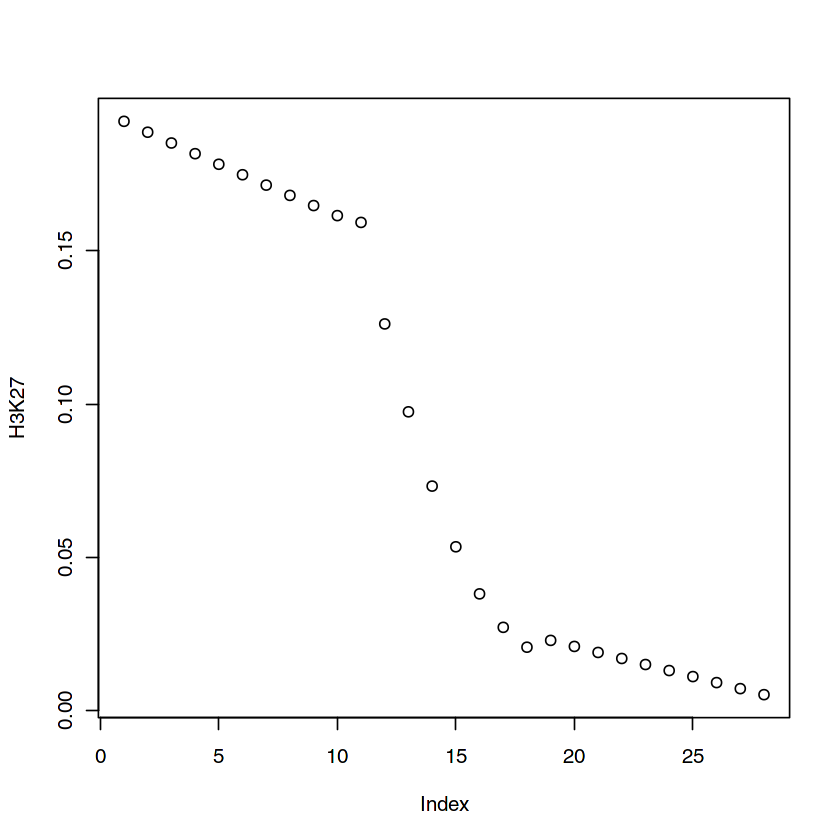

In [9]:
with(
  subset(trend_illu, celltype == "Germline" & label == "E"),
  plot(H3K27)
)

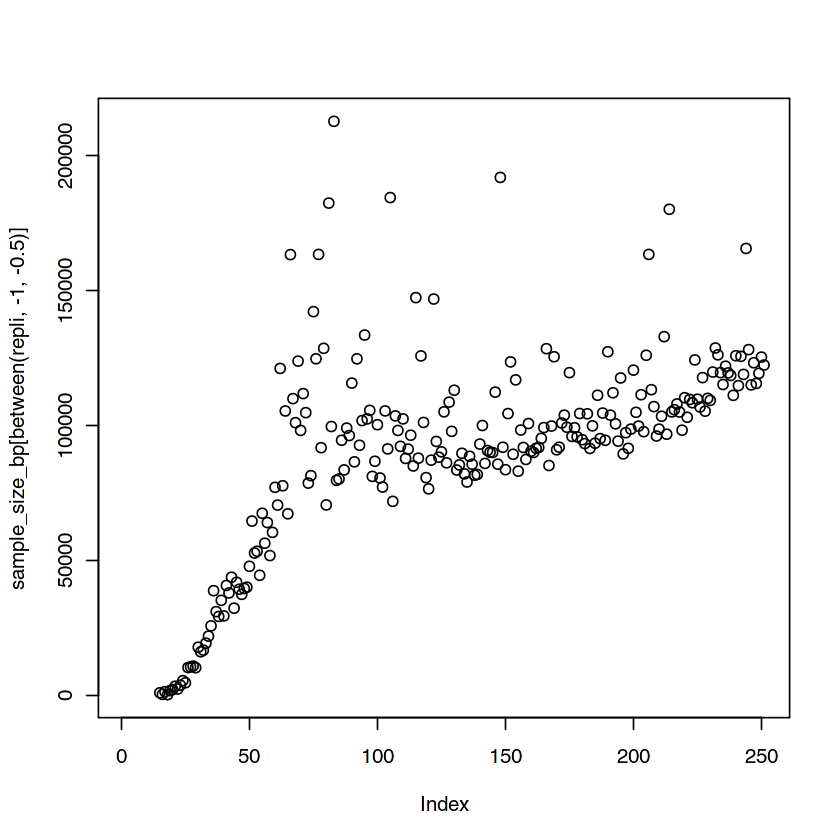

In [10]:
with(
  as.data.frame(repli.chic.projection.profile_Germline_chr),
  plot(sample_size_bp[between(repli, -1, -0.5)])
)

In [11]:
log2 <- \(v) log(v) / log(2)
trend_fit <- tibble(
  bind_rows(
    list(
      Germline = as.data.frame(repli.chic.projection.profile_Germline_chr),
      Somatic = as.data.frame(repli.chic.projection.profile_Somatic_chr)
    ),
    .id = "celltype"
  ),
  label = cut(repli, c(-Inf, -0.5, 0, 0.5, Inf)) %>%
    `levels<-`(value = c("L", "ML", "EM", "E")) %>%
    fct_relevel(c("E", "EM", "ML", "L")),
) %>%
  subset(sample_size_bp >= 500, select=c(celltype, label, repli, H3K4, H3K27, sample_size_bp)) %>%
  group_by(celltype, label) %>%
  summarise(
    lm = lm(
      log2(H3K27) ~ log2(H3K4),
      weights = sample_size_bp
    ) %>%
      list(),
    n = sum(sample_size_bp / max(sample_size_bp)),
    Var_H3K4  = weighted.mean(log2(H3K4 )^2 - weighted.mean(log2(H3K4 ), sample_size_bp)^2, sample_size_bp),
    Var_H3K27 = weighted.mean(log2(H3K27)^2 - weighted.mean(log2(H3K27), sample_size_bp)^2, sample_size_bp),
    Var_Uniform = weighted.mean(seq(0, 1, length.out=length(H3K4))^2 - weighted.mean(seq(0, 1, length.out=length(H3K4)), sample_size_bp)^2, sample_size_bp) / 1.5^2,
    Arc_Length = trend_illu[
      head(
        which(trend_illu$celltype == celltype[1] & trend_illu$label == label[1]),
        1
      ),
    ]$arclength,
    R = coef(lm[[1]])[2] / (sqrt(Var_H3K27) / sqrt(Var_H3K4)),
    R2 = R^2,
    .groups = "drop"
  ) %>%
  print()
print(
  squeezeVar(
    trend_fit$Var_Uniform,
    df = trend_fit$n-1
  )
)

# A tibble: 8 × 10
  celltype label lm         n Var_H3K4 Var_H3K27 Var_Uniform Arc_Length       R
  <chr>    <fct> <list> <dbl>    <dbl>     <dbl>       <dbl>      <dbl>   <dbl>
1 Germline E     <lm>   127.  0.000607  0.000303      0.0188     0.239   0.743 
2 Germline EM    <lm>   169.  0.000998  0.000686      0.0407     0.138  -0.222 
3 Germline ML    <lm>   106.  0.00233   0.00121       0.0347     0.191   0.721 
4 Germline L     <lm>   101.  0.0257    0.0144        0.0303     0.0285  0.628 
5 Somatic  E     <lm>   111.  0.000599  0.000631      0.0204     0.259   0.701 
6 Somatic  EM    <lm>   172.  0.00663   0.00192       0.0354     0.419   0.901 
7 Somatic  ML    <lm>    94.8 0.00593   0.00517       0.0375     0.207   0.651 
8 Somatic  L     <lm>   128.  0.00155   0.000377      0.0221     0.301  -0.0336
# ℹ 1 more variable: R2 <dbl>
$df.prior
[1] 27.87654

$var.prior
[1] 0.02806867

$var.post
[1] 0.02050701 0.03887061 0.03331703 0.02980516 0.02194673 0.03439612 0.03535612
[8] 0.023

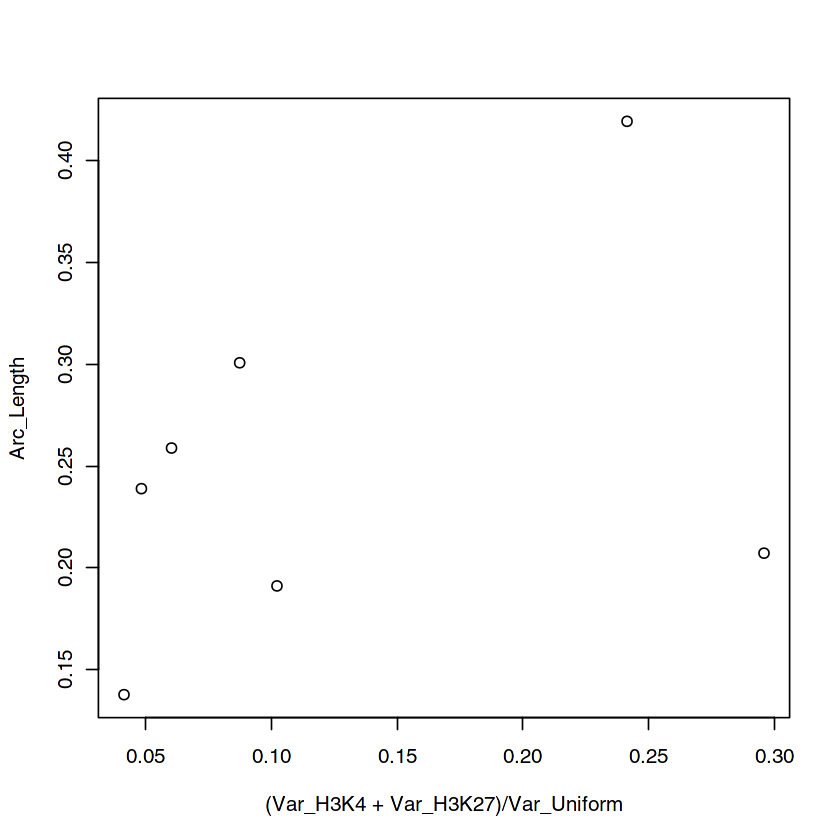

In [12]:
with(
  trend_fit[-4, ],
  plot(
    (Var_H3K4 + Var_H3K27) / Var_Uniform,
    Arc_Length
  )
)

In [13]:
lm(Arc_Length^2 ~ 0 + I(Var_H3K4 + Var_H3K27) + I(Var_Uniform - Mean_Var_Uniform), data=tibble(trend_fit, Mean_Var_Uniform = mean(Var_Uniform)), subset=c(1:3, 5:8))


Call:
lm(formula = Arc_Length^2 ~ 0 + I(Var_H3K4 + Var_H3K27) + I(Var_Uniform - 
    Mean_Var_Uniform), data = tibble(trend_fit, Mean_Var_Uniform = mean(Var_Uniform)), 
    subset = c(1:3, 5:8))

Coefficients:
          I(Var_H3K4 + Var_H3K27)  I(Var_Uniform - Mean_Var_Uniform)  
                           13.691                             -4.163  


In [14]:
summary(trend)

   celltype         label     repli.new            H3K4          
 Length:74          E :15   Min.   :-0.9500   Min.   :-0.152323  
 Class :character   EM:20   1st Qu.:-0.4875   1st Qu.: 0.009264  
 Mode  :character   ML:20   Median :-0.0250   Median : 0.114196  
                    L :19   Mean   :-0.0250   Mean   : 0.125244  
                            3rd Qu.: 0.4375   3rd Qu.: 0.225792  
                            Max.   : 0.9000   Max.   : 0.410831  
     H3K27          
 Min.   :-0.048925  
 1st Qu.: 0.005064  
 Median : 0.065092  
 Mean   : 0.079699  
 3rd Qu.: 0.119371  
 Max.   : 0.278749  

Linking to: OpenSSL 1.1.1f  31 Mar 2020



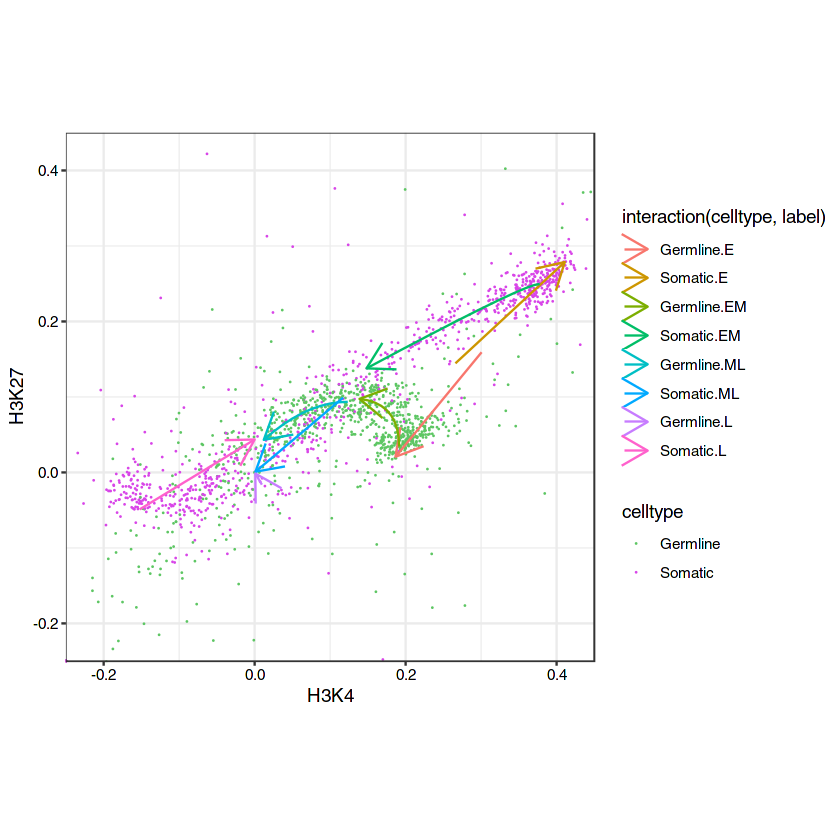

In [15]:
library(ggnewscale)
library(ggplot2)
library(openssl)
ggplot(
  trend,
  aes(H3K4, H3K27)
) +
  geom_point(
    aes(color = celltype),
    data = bind_rows(
      list(
        Germline = as.data.frame(log(repli.chic.projection.profile_Germline_chr[, c("H3K4", "H3K27")]) / log(2)),
        Somatic = as.data.frame(log(repli.chic.projection.profile_Somatic_chr[, c("H3K4", "H3K27")]) / log(2))
      ),
      .id = "celltype"
    ) %>%
      arrange(md5(as.character(str_glue("{celltype}:{H3K4}:{H3K27}")))),
    stroke = NA,
    size = 0.5
  ) +
  scale_color_manual(values = setNames(chic_line_track_colors, NULL)) +
  new_scale_color() +
  geom_path(aes(color = interaction(celltype, label)), arrow = arrow()) +
  coord_cartesian(c(-0.25,0.45), c(-0.25,0.45), exp=F) +
  theme(aspect.ratio = 1)

In [16]:
chic_line_track_colors

$germline
[1] "#5DC663"

$somatic
[1] "#D845E8"

# A tibble: 65 × 3
   celltype H3K4[,1] H3K27[,1]
   <chr>       <dbl>     <dbl>
 1 Germline    0.304    0.164 
 2 Germline    0.267    0.118 
 3 Germline    0.241    0.0863
 4 Germline    0.227    0.0676
 5 Germline    0.218    0.0569
 6 Germline    0.210    0.0486
 7 Germline    0.203    0.0429
 8 Germline    0.196    0.0398
 9 Germline    0.191    0.0391
10 Germline    0.185    0.0410
# ℹ 55 more rows


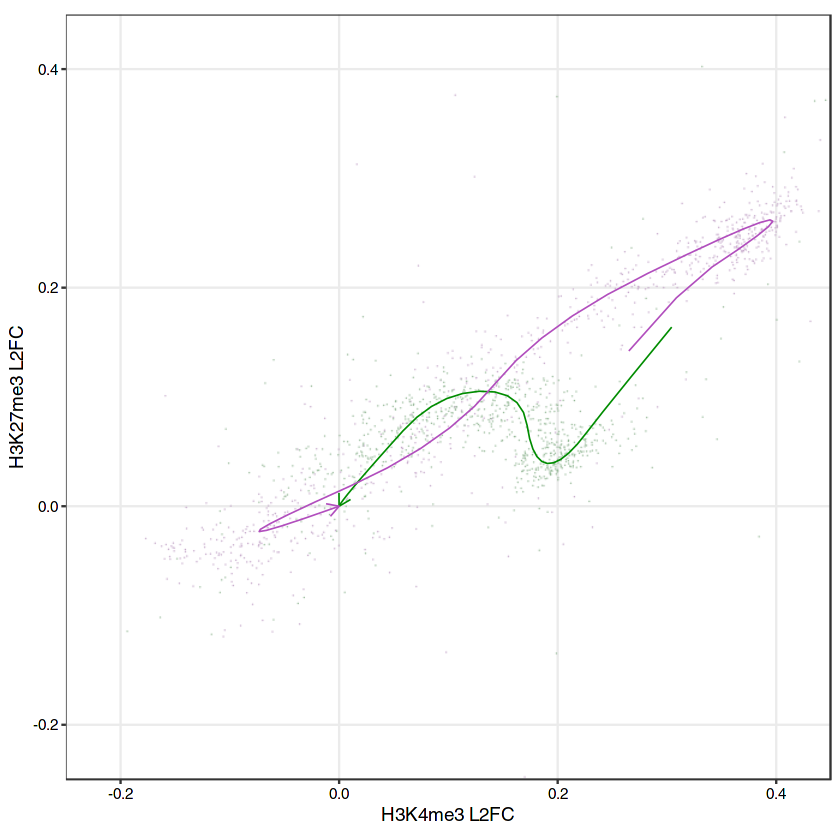

In [17]:
globaltrend <- trend %>%
  group_by(celltype) %>%
  subset(repli.new >= -0.7) %>%
  reframe(
    across(
      c(H3K4, H3K27),
      \(v) {
        X <- bSpline(repli.new[!is.na(H3K4)], knots = c(-0.25, 0, 0.25, 0.75), deg=2)
        Y <- v[!is.na(H3K4)]
        X %*% coef(lsfit(X, Y, int=F))
      }
    )
  ) %>%
  print()
globalrepli <- ggplot(globaltrend, aes(H3K4, H3K27, color=celltype)) +
  rasterise(
    geom_point(
      data = bind_rows(
        list(
          Germline = as.data.frame(log(repli.chic.projection.profile_Germline_chr[repli.chic.projection.profile_Germline_chr[, "repli"] >= -0.7, c("H3K4", "H3K27")]) / log(2)),
          Somatic = as.data.frame(log(repli.chic.projection.profile_Somatic_chr[repli.chic.projection.profile_Somatic_chr[, "repli"] >= -0.7, c("H3K4", "H3K27")]) / log(2))
        ),
        .id = "celltype"
      ) %>%
        arrange(md5(as.character(str_glue("{celltype}:{H3K4}:{H3K27}")))),
      stroke = NA,
      size = 0.125
    ),
    dpi=100
  ) +
  scale_color_manual(values = muted(unlist(chic_line_track_colors, use.names=F), c=30, l=70)) +
  new_scale_color() +
  geom_path(
    aes(color=celltype), arrow = arrow(length = unit(8, "pt")),
    linewidth = 25.4 / 72
  ) +
  scale_color_manual(values = muted(unlist(chic_line_track_colors, use.names=F), c=80, l=50)) +
  coord_cartesian(c(-0.25,0.45), c(-0.25,0.45), exp=F) +
  labs(x = "H3K4me3 L2FC", y = "H3K27me3 L2FC") +
  theme(aspect.ratio = 1, legend.position = "none", panel.grid.minor = element_blank())
globalrepli

## Conditional-on-Timing Total Variance & Arc Length

In [18]:
overlaps <- cross_join(
  tibble(celltype = c("Germline", "Somatic")),
  tibble(label = c("E", "EM", "ML", "L") %>% factor(., .))
) %>%
  group_by(celltype) %>%
  mutate(
    i = split(
      as.list(
        findOverlaps(chic.tile.diameter_1000_chr, chic.tile.diameter_500_score_chr)
      ),
      cut(
        get(str_glue("repli.timing_{celltype[1]}_chr"))$score,
        c(-Inf, -0.5, 0, 0.5, Inf)
      ) %>%
        factor(c("(0.5, Inf]", "(0,0.5]", "(-0.5,0]", "(-Inf,-0.5]"))
    ) %>%
      sapply(\(lst) unique(do.call(c, lst)))
  ) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i              
  <chr>    <fct> <named list>   
1 Germline E     <int [393,956]>
2 Germline EM    <int [385,440]>
3 Germline ML    <int [422,895]>
4 Germline L     <int [175,825]>
5 Somatic  E     <int [302,949]>
6 Somatic  EM    <int [449,353]>
7 Somatic  ML    <int [301,666]>
8 Somatic  L     <int [324,148]>


In [19]:
# 500 bp window, 100 bp step: Grab the windows that are centered e.g. 1-500, 501-1000.
overlaps <- overlaps %>%
  mutate(i = i %>% sapply(\(v) subset(v, v %% 5 == 3 & v <= sum(seqnames(chic.tile.diameter_500_score_chr) %in% names(chr.lengths))))) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i             
  <chr>    <fct> <named list>  
1 Germline E     <int [78,707]>
2 Germline EM    <int [77,004]>
3 Germline ML    <int [84,460]>
4 Germline L     <int [34,926]>
5 Somatic  E     <int [60,589]>
6 Somatic  EM    <int [89,800]>
7 Somatic  ML    <int [59,990]>
8 Somatic  L     <int [64,718]>


In [20]:
overlaps_uniform <- cross_join(
  tibble(celltype = c("Germline", "Somatic")),
  tibble(label = c("E", "EM", "ML", "L") %>% factor(., .))
) %>%
  group_by(celltype) %>%
  mutate(
    i = order(
      get(str_glue("repli.timing_{celltype[1]}_chr"))$score %>%
        head(sum(seqnames(chic.tile.diameter_1000_chr) %in% names(chr.lengths)))
    ) %>%
      split(
        cut(seq_along(.), seq(0, length(.), length.out = 5))
      ) %>%
      sapply(\(diameter_1000_inds) chic.tile.diameter_1000_chr[diameter_1000_inds] %>%
        findOverlaps(chic.tile.diameter_500_score_chr) %>%
        to() %>%
        subset(. %% 5 == 3) %>%
        unique()
      )
  ) %>%
  print()

# A tibble: 8 × 3
# Groups:   celltype [2]
  celltype label i             
  <chr>    <fct> <named list>  
1 Germline E     <int [68,772]>
2 Germline EM    <int [68,776]>
3 Germline ML    <int [68,776]>
4 Germline L     <int [68,773]>
5 Somatic  E     <int [68,775]>
6 Somatic  EM    <int [68,771]>
7 Somatic  ML    <int [68,776]>
8 Somatic  L     <int [68,775]>


In [21]:
chromatin <- overlaps %>%
  group_by(celltype, label) %>%
  reframe(
    tibble(
      H3 = get(str_glue("chic.experiment.quantify_H3K27_{celltype[1]}_peakcalling.broad_chr"))$score.molH3[i[[1]]],
      H3K4 = get(str_glue("chic.experiment.quantify_H3K4_{celltype[1]}_peakcalling.broad_chr"))$L2FC[i[[1]]],
      H3K27 = get(str_glue("chic.experiment.quantify_H3K27_{celltype[1]}_peakcalling.broad_chr"))$L2FC[i[[1]]],
    )
  ) %>%
  subset(between(abs(H3K4), 1e-6, 9.9) & between(abs(H3K27), 1e-6, 9.9)) %>%
  print()

# A tibble: 501,201 × 5
   celltype label    H3    H3K4   H3K27
   <chr>    <fct> <dbl>   <dbl>   <dbl>
 1 Germline E     0.456 -0.0578 -0.196 
 2 Germline E     1.20  -0.286   0.339 
 3 Germline E     1.31  -0.869  -0.995 
 4 Germline E     1.34  -0.757  -0.220 
 5 Germline E     0.841 -1.56   -2.52  
 6 Germline E     1.36   0.826  -0.392 
 7 Germline E     1.45   0.427   0.0677
 8 Germline E     1.29   0.0333  0.316 
 9 Germline E     1.30  -0.218  -0.267 
10 Germline E     1.06  -1.18   -3.17  
# ℹ 501,191 more rows


In [22]:
Var_Total <- chromatin %>%
  group_by(celltype, label) %>%
  summarise(Var = var(H3K4) + var(H3K27), df = 2 * (length(H3K4) - 1)) %>%
  print()

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


# A tibble: 8 × 4
# Groups:   celltype [2]
  celltype label   Var     df
  <chr>    <fct> <dbl>  <dbl>
1 Germline E     0.851 153266
2 Germline EM    0.812 145612
3 Germline ML    0.744 151282
4 Germline L     1.14   51296
5 Somatic  E     0.831 119214
6 Somatic  EM    0.802 172492
7 Somatic  ML    0.768  98408
8 Somatic  L     0.628 110816


[1] 0.2340888 0.4681775


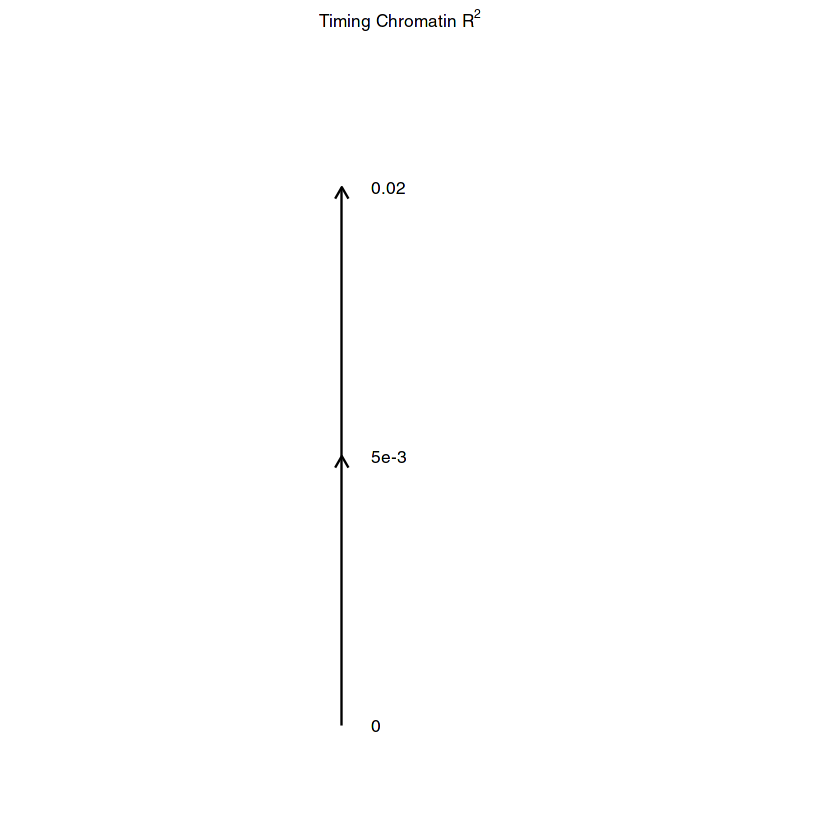

In [23]:
Var_Total_Scalar <- with(Var_Total, squeezeVar(Var, df))$var.prior
breaks <- c(
  sqrt(13.691 * 5e-3 * Var_Total_Scalar),
  sqrt(13.691 * 0.02 * Var_Total_Scalar)
) %>%
  print()
expl_var_legend <- ggplot(
  tribble(
    ~x, ~y, ~xend, ~yend,
    0, -0.2, 0, -0.2 + breaks[1],
    0, -0.2 + breaks[1], 0, -0.2 + breaks[2],
   #  0, -0.2 + breaks[2], 0, 0.4
  ),
  aes(x, y, xend=xend, yend=yend)
) +
  geom_segment(
    data = \(data) head(data, 2),
    arrow = arrow(length = unit(8, "pt")),
  ) +
  # geom_segment(
  #   data = \(data) tail(data, 1),
  # ) +
  annotate("text", 0.13, -0.2, hjust = 0, label = 0, size = 10 * 25.4 / 72) +
  annotate("text", 0.13, -0.2 + breaks[1], hjust = 0, label = "5e-3", size = 10 * 25.4 / 72) +
  annotate("text", 0.13, -0.2 + breaks[2], hjust = 0, label = 0.02, size = 10 * 25.4 / 72) +
  # annotate("segment", -0.1, 0.2, xend = 0.1, yend = 0.2) +
  coord_cartesian(c(-0.1, 0.8), c(-0.25, 0.45) - 0.05, exp=F) +
  labs(title = bquote("Timing Chromatin R"^2)) +
  theme_void() +
  theme(
    aspect.ratio = 4,
    plot.title = element_text(size = unit(10, "pt"))
  )
expl_var_legend

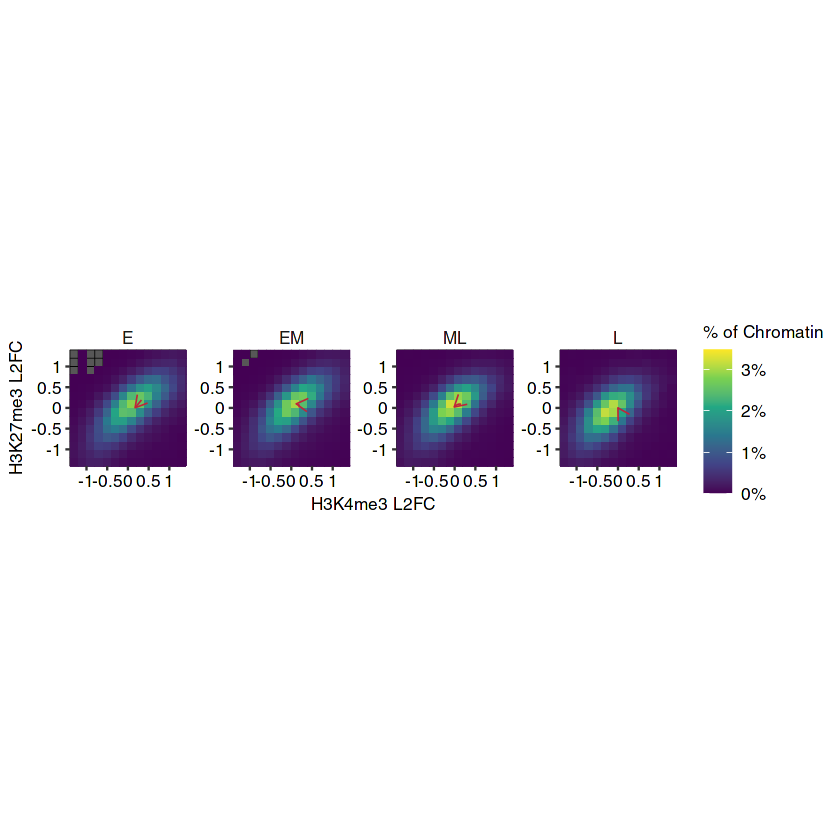

In [24]:
library(ggplot2)
library(scales)
plot_limits <- 7.4
annotate_polygon <- 1.38
p <- ggplot(
  chromatin,
  aes(H3K4, H3K27, fill = after_stat(density))
) +
  facet_wrap(vars(label), scales = "free", nrow = 1) +
  geom_bin2d(binwidth = 0.2) +
  # geom_smooth(aes(fill=NULL), method = "lm") +
  geom_path(
    aes(fill = NULL),
    data = \(chromatin) trend_illu %>%
      subset(celltype == chromatin$celltype[1]),
    color = "#c0253a",
    arrow = arrow(length = unit(8, "pt")),
    linewidth = 1 * 25.4 / 72,
  ) +
  scale_fill_viridis_c(
    "% of Chromatin",
    limits = c(0, 0.035),
    labels = percent
  ) +
  scale_x_continuous(
    limits = c(-plot_limits, plot_limits), expand=c(0, 0),
    minor_breaks = seq(-1.4, 1.4, by=0.2),
    labels = as.numeric
  ) +
  scale_y_continuous(
    limits = c(-plot_limits, plot_limits), expand=c(0, 0),
    minor_breaks = seq(-1.4, 1.4, by=0.2),
    labels = as.numeric
  ) +
  coord_cartesian(c(-1.4,1.4), c(-1.4,1.4)) +
  labs(x = "H3K4me3 L2FC", y = "H3K27me3 L2FC") +
  theme(
    aspect.ratio = 1,
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 10),
    panel.background = element_rect(fill = "#575757"),
    panel.grid = element_line(color = "black", linewidth = 0.5 * 25.4 / 72),
    panel.grid.minor = element_line(color = "black", linewidth = 0.5 * 25.4 / 72),
    panel.border = element_blank(),
    plot.title = element_text(size = 10),
    strip.background = element_blank(),
    strip.text = element_text(size = 10, margin = margin(2, 2, 2, 2)),
  )
p

In [25]:
print(subset(chromatin, label == "E"))

# A tibble: 136,242 × 5
   celltype label    H3    H3K4   H3K27
   <chr>    <fct> <dbl>   <dbl>   <dbl>
 1 Germline E     0.456 -0.0578 -0.196 
 2 Germline E     1.20  -0.286   0.339 
 3 Germline E     1.31  -0.869  -0.995 
 4 Germline E     1.34  -0.757  -0.220 
 5 Germline E     0.841 -1.56   -2.52  
 6 Germline E     1.36   0.826  -0.392 
 7 Germline E     1.45   0.427   0.0677
 8 Germline E     1.29   0.0333  0.316 
 9 Germline E     1.30  -0.218  -0.267 
10 Germline E     1.06  -1.18   -3.17  
# ℹ 136,232 more rows


In [26]:
print(subset(chromatin, label == "EM"))

# A tibble: 159,054 × 5
   celltype label      H3   H3K4   H3K27
   <chr>    <fct>   <dbl>  <dbl>   <dbl>
 1 Germline EM    1.36     0.573  0.255 
 2 Germline EM    0.995    0.434 -0.326 
 3 Germline EM    1.25     0.127 -0.198 
 4 Germline EM    1.26     0.158 -0.100 
 5 Germline EM    1.08    -0.560  0.200 
 6 Germline EM    0.0718   0.964 -0.222 
 7 Germline EM    0.00769  1.83   2.11  
 8 Germline EM    1.41    -1.39  -1.12  
 9 Germline EM    1.59    -0.139 -0.466 
10 Germline EM    2.22     0.275 -0.0369
# ℹ 159,044 more rows


In [27]:
correlations <- chromatin %>%
  group_by(celltype, label) %>%
  reframe(
    across(
      everything(),
      list(
        z = \(v) scale(v)[, 1],
        var = var
      )
    )
  ) %>%
  print() %>%
  group_by(label) %>%
  summarise(
    R_Germline = cor(H3K4_z[celltype == "Germline"], H3K27_z[celltype == "Germline"]),
    R_Somatic = cor(H3K4_z[celltype == "Somatic"], H3K27_z[celltype == "Somatic"]),
    Var_Germline_H3K4 = H3K4_var[match("Germline", celltype)],
    Var_Germline_H3K27 = H3K27_var[match("Germline", celltype)],
    Var_Somatic_H3K4 = H3K4_var[match("Somatic", celltype)],
    Var_Somatic_H3K27 = H3K27_var[match("Somatic", celltype)],
    model = lm(
        H3K27_z ~ H3K4_z * celltype
    ) %>%
      list()
  ) %>%
  print(width = 180)

# A tibble: 501,201 × 8
   celltype label     H3_z H3_var  H3K4_z H3K4_var H3K27_z H3K27_var
   <chr>    <fct>    <dbl>  <dbl>   <dbl>    <dbl>   <dbl>     <dbl>
 1 Germline E     -1.71     0.125 -0.180     0.440  -0.196     0.410
 2 Germline E      0.385    0.125 -0.525     0.440   0.640     0.410
 3 Germline E      0.700    0.125 -1.40      0.440  -1.44      0.410
 4 Germline E      0.780    0.125 -1.23      0.440  -0.232     0.410
 5 Germline E     -0.628    0.125 -2.45      0.440  -3.82      0.410
 6 Germline E      0.825    0.125  1.15      0.440  -0.500     0.410
 7 Germline E      1.08     0.125  0.550     0.440   0.216     0.410
 8 Germline E      0.644    0.125 -0.0431    0.440   0.604     0.410
 9 Germline E      0.680    0.125 -0.421     0.440  -0.305     0.410
10 Germline E     -0.00780  0.125 -1.87      0.440  -4.84      0.410
# ℹ 501,191 more rows
# A tibble: 4 × 8
  label R_Germline R_Somatic Var_Germline_H3K4 Var_Germline_H3K27
  <fct>      <dbl>     <dbl>             <

In [28]:
summary(correlations$model[[1]])


Call:
lm(formula = H3K27_z ~ H3K4_z * celltype)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4009 -0.3803  0.0617  0.4664  5.8550 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             2.071e-17  2.700e-03   0.000        1    
H3K4_z                  6.727e-01  2.700e-03 249.161  < 2e-16 ***
celltypeSomatic        -9.488e-17  4.082e-03   0.000        1    
H3K4_z:celltypeSomatic -1.907e-02  4.082e-03  -4.672 2.98e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7474 on 136238 degrees of freedom
Multiple R-squared:  0.4414,	Adjusted R-squared:  0.4414 
F-statistic: 3.589e+04 on 3 and 136238 DF,  p-value: < 2.2e-16


In [29]:
print(trend_fit)

# A tibble: 8 × 10
  celltype label lm         n Var_H3K4 Var_H3K27 Var_Uniform Arc_Length       R
  <chr>    <fct> <list> <dbl>    <dbl>     <dbl>       <dbl>      <dbl>   <dbl>
1 Germline E     <lm>   127.  0.000607  0.000303      0.0188     0.239   0.743 
2 Germline EM    <lm>   169.  0.000998  0.000686      0.0407     0.138  -0.222 
3 Germline ML    <lm>   106.  0.00233   0.00121       0.0347     0.191   0.721 
4 Germline L     <lm>   101.  0.0257    0.0144        0.0303     0.0285  0.628 
5 Somatic  E     <lm>   111.  0.000599  0.000631      0.0204     0.259   0.701 
6 Somatic  EM    <lm>   172.  0.00663   0.00192       0.0354     0.419   0.901 
7 Somatic  ML    <lm>    94.8 0.00593   0.00517       0.0375     0.207   0.651 
8 Somatic  L     <lm>   128.  0.00155   0.000377      0.0221     0.301  -0.0336
# ℹ 1 more variable: R2 <dbl>


In [30]:
subset(trend, celltype == "Somatic" & label == "E") %>% reframe(across(c(H3K4, H3K27), diff)) %>%
  print() %>%
  reframe(across(c(H3K4, H3K27), \(v) c(quantile(v, c(0, 0.25)), mean(v), quantile(v, c(0.5, 0.75, 1))))) %>%
  with(H3K27 / H3K4)

# A tibble: 6 × 2
     H3K4   H3K27
    <dbl>   <dbl>
1 0.0394  0.0365 
2 0.0333  0.0308 
3 0.0272  0.0252 
4 0.0211  0.0195 
5 0.0150  0.0139 
6 0.00890 0.00825


0%       25%                 50%       75%      100% 
0.9265443 0.9265443 0.9265443 0.9265443 0.9265443 0.9265443

In [31]:
trend %>% group_by(celltype, label) %>% summarise(mean(diff(H3K27) / diff(H3K4), na.rm=T), mean(diff(H3K27), na.rm=T) / mean(diff(H3K4), na.rm=T))

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


celltype,label,"mean(diff(H3K27)/diff(H3K4), na.rm = T)","mean(diff(H3K27), na.rm = T)/mean(diff(H3K4), na.rm = T)"
<chr>,<fct>,<dbl>,<dbl>
Germline,E,1.2141208,1.2141208
Germline,EM,-3.5660650,-1.2001909
Germline,ML,0.4502152,0.4526578
Germline,L,-1.6856922,-1.6856922
Somatic,E,0.9265443,0.9265443
Somatic,EM,0.4455595,0.4873894
Somatic,ML,0.8451466,0.8451466
Somatic,L,0.6074404,0.6074404


In [32]:
1/1.214

[1] 0.8237232

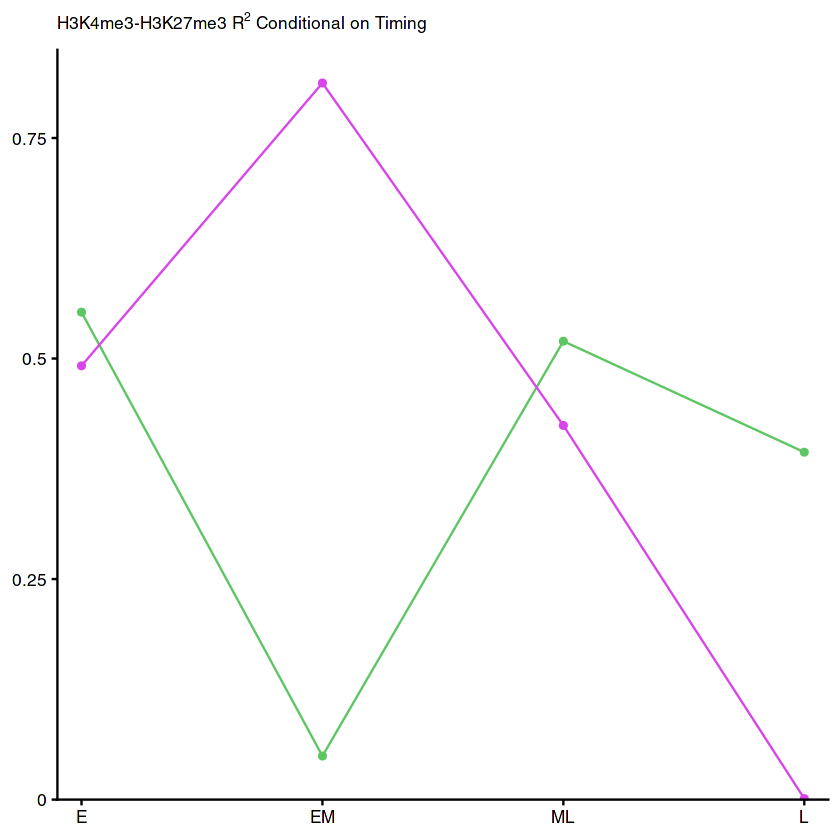

In [33]:
library(cowplot)
corrplot <- ggplot(trend_fit, aes(label, R2)) +
  geom_line(aes(group = 1),data = \(data) data %>% subset(celltype == "Germline"), color = chic_line_track_colors$germline) +
  geom_point(data = \(data) data %>% subset(celltype == "Germline"), color = chic_line_track_colors$germline) +
  geom_line(aes(group = 1),data = \(data) data %>% subset(celltype == "Somatic"), color = chic_line_track_colors$somatic) +
  geom_point(data = \(data) data %>% subset(celltype == "Somatic"), color = chic_line_track_colors$somatic) +
  scale_y_continuous(breaks = c(0, 0.25, 0.5, 0.75), labels = as.numeric) +
  coord_cartesian(c(0.9, 4.1), c(0, 0.85), ex=F) +
  labs(title=bquote("H3K4me3-H3K27me3 R"^2*" Conditional on Timing"), x = NULL, y = NULL) +
  theme_cowplot() +
  theme(
    axis.text = element_text(size = 10),
    plot.title = element_text(size = 10)
  )
corrplot

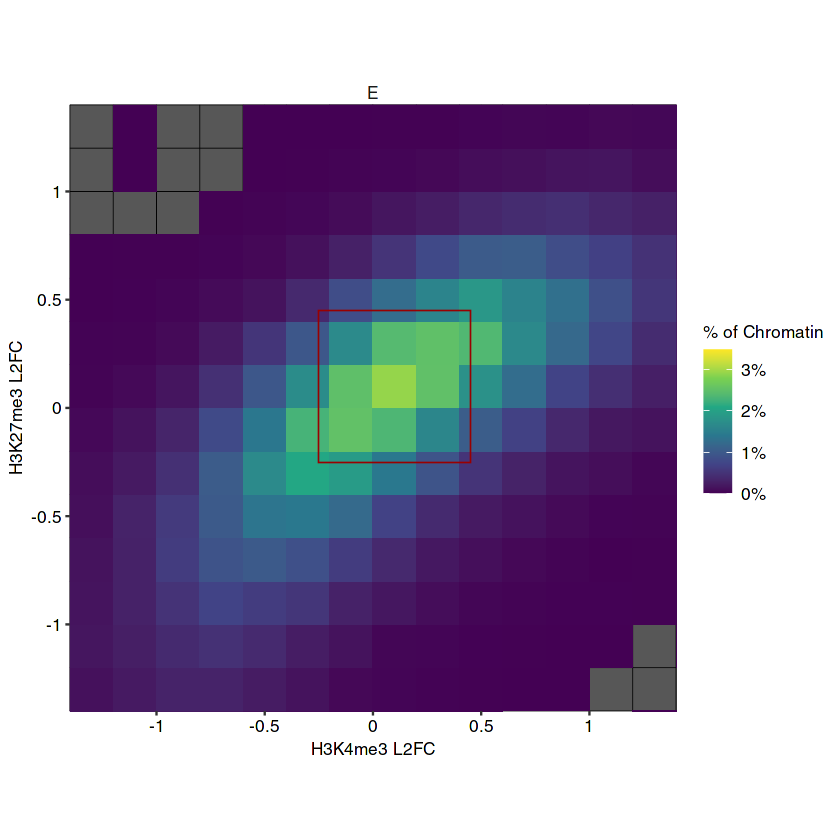

In [34]:
p %>%
  `$<-`("data", value = .$data %>% subset(celltype == "Germline" & label == "E")) %>%
  `$<-`("layers", value = head(.$layers, 1)) %>%
  `+`(
    annotate(
      "rect",
      xmin = -0.251,
      xmax = 0.451,
      ymin = -0.251,
      ymax = 0.451,
      color = "#990000",
      fill = "transparent",
      linewidth = 1 * 25.4 / 72
    )
  )

In [35]:
p$layers[[2]]

mapping: fill = NULL 
geom_path: lineend = butt, linejoin = round, linemitre = 10, arrow = list(angle = 30, length = 8, ends = 2, type = 1), na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

In [36]:
write(deparse(as.list(p$layers[[2]])), stdout())

list(mapping = structure(list(fill = NULL), class = "uneval"), 
    geom_params = list(lineend = "butt", linejoin = "round", 
        linemitre = 10, arrow = structure(list(angle = 30, length = structure(8, unit = 8L, class = c("simpleUnit", 
        "unit", "unit_v2")), ends = 2L, type = 1L), class = "arrow"), 
        na.rm = FALSE), layer_data = function (self, plot_data) 
    {
        if (is.waive(self$data)) {
            data <- plot_data
        }
        else if (is.function(self$data)) {
            data <- self$data(plot_data)
            if (!is.data.frame(data)) {
                cli::cli_abort("{.fn layer_data} must return a {.cls data.frame}")
            }
        }
        else {
            data <- self$data
        }
        if (is.null(data) || is.waive(data)) 
            data
        else unrowname(data)
    }, compute_statistic = function (self, data, layout) 
    {
        if (empty(data)) 
            return(data_frame0())
        self$computed_stat_params <- s

In [37]:
match("aes_params", names(p$layers[[2]]))

[1] 13

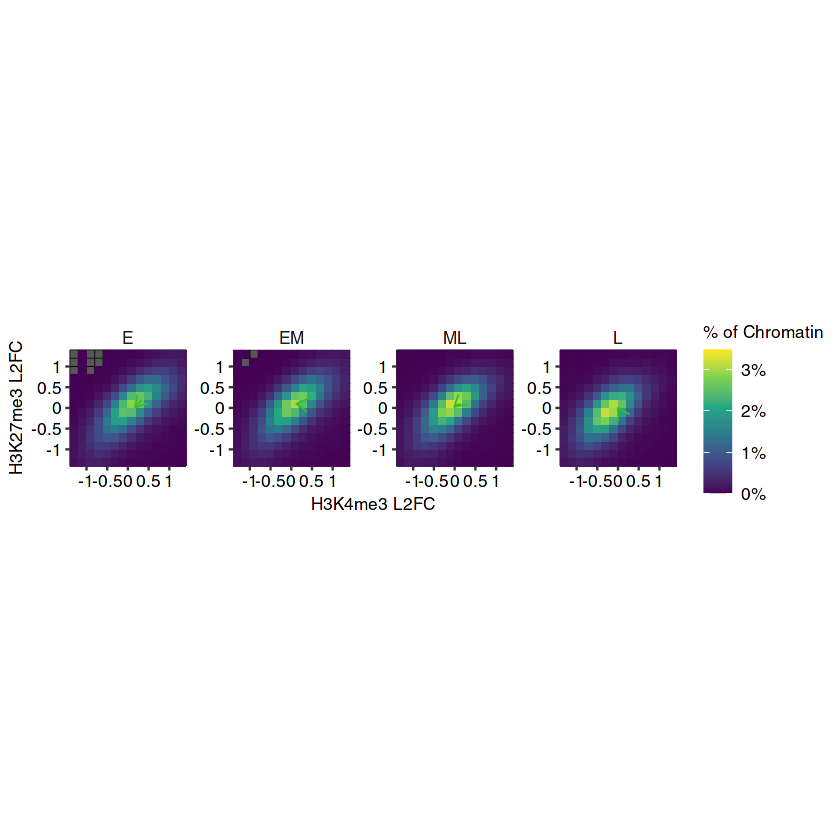

In [38]:
p %>%
  `$<-`(
    "layers",
    value = list(
      .$layers[[1]],
      geom_path(
        aes(fill = NULL),
        data = \(chromatin) trend_illu %>%
          subset(celltype == chromatin$celltype[1]),
        color = "#32c025",
        arrow = arrow(length = unit(8, "pt")),
        linewidth = 1 * 25.4 / 72,
      )
    )
  )

In [48]:
chic_line_track_colors

$germline
[1] "#5DC663"

$somatic
[1] "#D845E8"

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


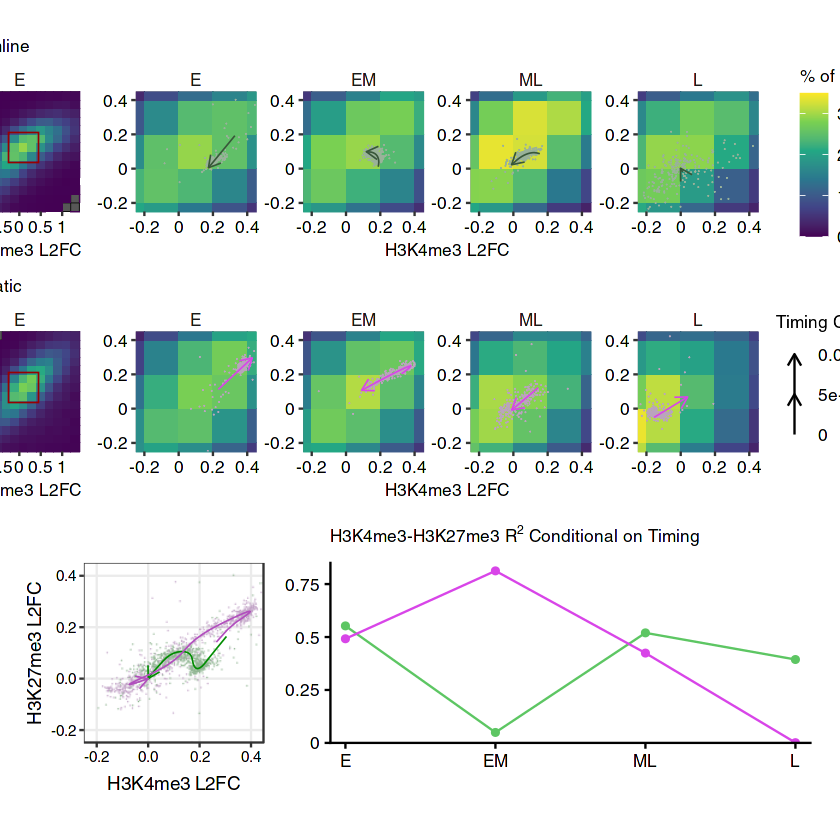

In [52]:
library(egg)
library(grid)
library(gtable)
trend_input_log2 <- mutate(
  trend_input,
  H3K4 = log2(H3K4),
  H3K27 = log2(H3K27)
)
pointcloud_layer <- rasterise(
  geom_point(
    aes(fill = NULL, color = color),
    \(chromatin) tibble(
      subset(trend_input_log2, celltype == chromatin$celltype[1]),
      color = muted(unlist(chic_line_track_colors), c=20, l=70)[
        tolower(chromatin$celltype[[1]])
      ],
    ),
    stroke = NA,
    size = 0.5
  ),
  dpi = 300
)
Germline_Report <- set_panel_size(
  p %>%
    `$<-`("data", value = .$data %>% subset(celltype == "Germline")) %>%
    `$<-`(
      "layers",
      value = list(
        .$layers[[1]],
        pointcloud_layer,
        geom_path(
          aes(fill = NULL),
          data = \(chromatin) trend_illu %>%
            subset(celltype == chromatin$celltype[1]),
          color = "#385739",
          arrow = arrow(length = unit(8, "pt")),
          linewidth = 1 * 25.4 / 72,
        )
      )
    ) %>%
    `+`(
      list(
        coord_cartesian(c(-0.25,0.45), c(-0.25,0.45), exp=F),
        scale_color_identity(),
        labs(y = NULL)
      )
    ),
  w = unit(1, "in"),
  h = unit(1, "in")
)
Germline_Report <- Germline_Report %>%
  cbind(
    set_panel_size(
      p %>%
        `$<-`("data", value = .$data %>% subset(celltype == "Germline" & label == "E")) %>%
        `$<-`("layers", value = head(.$layers, 1)) %>%
        `+`(
          list(
            annotate(
              "rect",
              xmin = -0.251,
              xmax = 0.451,
              ymin = -0.251,
              ymax = 0.451,
              color = "#990000",
              fill = "transparent",
              linewidth = 1 * 25.4 / 72
            ),
            labs(title = "Germline"),
            theme(legend.position = "none")
          )
        ),
      w = unit(1, "in"),
      h = unit(1, "in")
    ),
    .
  )

Somatic_Report <- set_panel_size(
  p %>%
    `$<-`("data", value = .$data %>% subset(celltype == "Somatic")) %>%
    `$<-`(
      "layers",
      value = list(
        .$layers[[1]],
        pointcloud_layer,
        geom_path(
          aes(fill = NULL),
          data = \(chromatin) trend_illu %>%
            subset(celltype == chromatin$celltype[1]),
          color = "#D845E8",
          arrow = arrow(length = unit(8, "pt")),
          linewidth = 1 * 25.4 / 72,
        )
      )
    ) %>%
    `+`(
      list(
        coord_cartesian(c(-0.25,0.45), c(-0.25,0.45), exp=F),
        scale_color_identity(),
        labs(y = NULL),
        guides(
          fill = guide_colorbar(
            barheight = 0
          )
        ),
        theme(
          legend.text = element_blank(),
          legend.title = element_text(color = "transparent")
        )
      )
    ),
  w = unit(1, "in"),
  h = unit(1, "in")
)
Somatic_Report <- Somatic_Report %>%
  cbind(
    set_panel_size(
      p %>%
        `$<-`("data", value = .$data %>% subset(celltype == "Somatic" & label == "E")) %>%
        `$<-`("layers", value = head(.$layers, 1)) %>%
        `+`(
          list(
            annotate(
              "rect",
              xmin = -0.251,
              xmax = 0.451,
              ymin = -0.251,
              ymax = 0.451,
              color = "#990000",
              fill = "transparent",
              linewidth = 1 * 25.4 / 72
            ),
            labs(title = "Somatic"),
            theme(legend.position = "none")
          )
        ),
      w = unit(1, "in"),
      h = unit(1, "in")
    ),
    .
  )
Somatic_Report <- Somatic_Report %>%
  gtable_add_grob(
    ggplotGrob(expl_var_legend)$grobs[
      match("panel", ggplotGrob(expl_var_legend)$layout$name)
    ],
    t = .$layout$t[match("panel-1-1", .$layout$name)],
    l = .$layout$l[match("guide-box", .$layout$name)]
  ) %>%
  gtable_add_grob(
    ggplotGrob(expl_var_legend)$grobs[
      match("title", ggplotGrob(expl_var_legend)$layout$name)
    ],
    t = .$layout$t[match("strip-t-1-1", .$layout$name)],
    l = .$layout$l[match("guide-box", .$layout$name)]
  )
Germline_Report$widths[Germline_Report$layout$l[match("guide-box", Germline_Report$layout$name)]] <- unit(3.5, "cm")
Somatic_Report$widths[Somatic_Report$layout$l[match("guide-box", Somatic_Report$layout$name)]] <- unit(3.5, "cm")
report <- gtable(
  unit(1, "null"),
  unit(c(2, 2, 2.5), "in")
) %>%
  gtable_add_grob(
    list(
      Germline_Report,
      Somatic_Report,
      cbind(
        set_panel_size(
          globalrepli,
          w = unit(1.5, "in"),
          h = unit(1.5, "in")
        ),
        set_panel_size(
          corrplot,
          w = unit(4, "in"),
          h = unit(1.5, "in")
        )
      )
    ),
    t = 1:3,
    l = 1
  )
grid.draw(report)

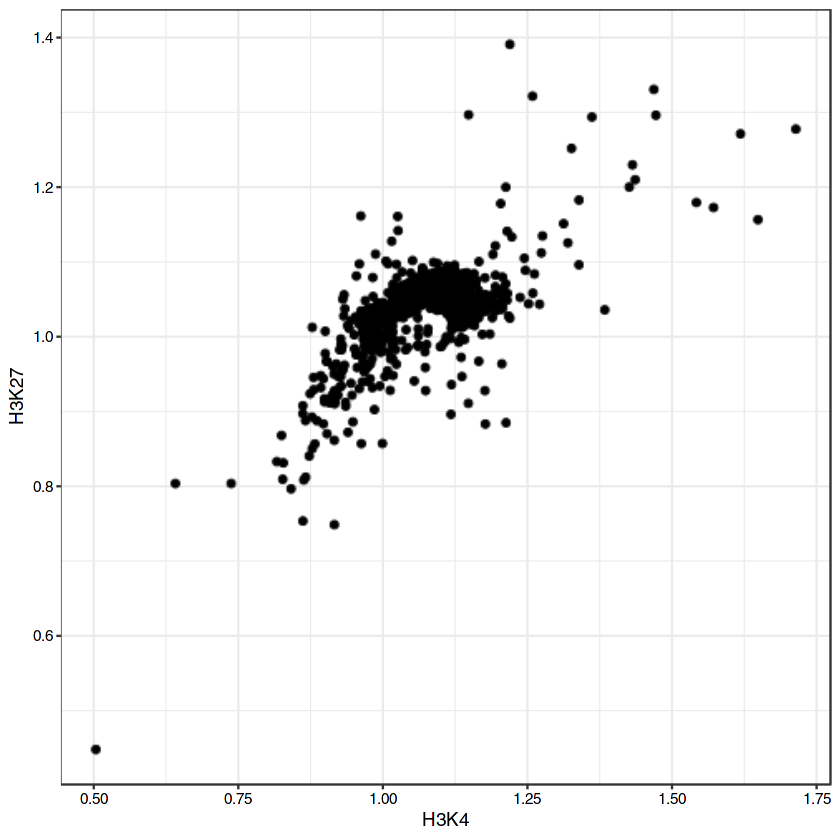

In [50]:
p$data %>%
  subset(celltype == "Germline") %>%
  ggplot(aes(H3K4, H3K27)) +
  rasterise(
    geom_point(
      data = 
        \(chromatin) subset(trend_input, celltype == chromatin$celltype[1])
    )
  )

In [53]:
library(Cairo)
CairoPDF("illustrations/Histone-Corr-Timing-Group-L2FC-Bar-Data.pdf", w = 11, h = 8.5)
grid.draw(report)
dev.off()

png 
  2